# Trabalho de Bioinformática
- Ana Cristina Silva de Oliveira, 11965630
- Fernando Henrique Paes Generich, 11795342
- Vítor Amorim Fróis, 12543440

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import Entrez, SeqIO, Seq
from tqdm import tqdm

## Leitura dos arquivos .gff3
Vamos selecionar todas as linhas em que a Strand é positiva:

In [ ]:
classes = [
  'Helitron',
  'LINE',
  'LTR',
  'MITE',
  'SINE',
  'TIR'
]

def process_file(element_class: str) -> pd.DataFrame:
  filename = f'gff3/TEAnnotationFinal_{element_class}.gff3'
  df = pd.read_csv(f'data/{filename}', sep='\t', header=None)
  df.drop(df[ df[6] != '+' ].index , inplace = True)
  df = df.drop( [1, 5, 7, 8], axis=1)
  df['Class'] = element_class
  return df

te_df = pd.DataFrame()

# Juntando os dados em um único DataFrame
for element_class in classes:
  te_df = pd.concat([te_df, process_file(element_class)], ignore_index=True)

# Renomeando colunas
te_df.rename(columns={0 : "Chr", 2: "FullClass", 3: "Start", 4: "End", 6: "Strand"}, inplace = True)

# Seleciona Chr numérico apenas
te_df = te_df[te_df['Chr'].astype(str).str.isdigit()]

te_df.head()

,Chr,Class,Start,End,Strand,Class
0,7,Class II subclass 2/Helitron/Helitron,82856122,82857584,+,Helitron
1,1,Class II subclass 2/Helitron/Helitron,239302471,239302834,+,Helitron
2,8,Class II subclass 2/Helitron/Helitron,2261318,2261604,+,Helitron
3,5,Class II subclass 2/Helitron/Helitron,124665404,124665608,+,Helitron
4,9,Class II subclass 2/Helitron/Helitron,77998293,78002783,+,Helitron


## Obtendo as sequências de cromossomos do NCBI
No total, são 10 cromossomos

In [366]:
Entrez.email = "fernando_gene@usp.br"

ind = 618874

allchromosomes = []

for i in tqdm(range(10)):
  gen_bank_term = "LR" + str(ind+i) + ".1"

  handle = Entrez.esearch(db="nucleotide", term=gen_bank_term, retmax="10")
  rec_list = Entrez.read(handle)
  handle.close()

  id_list = rec_list['IdList']
  handle = Entrez.efetch(db='nucleotide', id=id_list, rettype='fasta', retmode="text")
  recs = list(SeqIO.parse(handle, 'fasta'))
  handle.close()

  allchromosomes.append(recs[0])

100%|██████████| 10/10 [09:11<00:00, 55.14s/it]


In [367]:
chromosome_dict = {
  'Number': [],
  'Sequence': []
}

for i in allchromosomes:
  chromosome_dict['Number'].append(i.id)
  chromosome_dict['Sequence'].append(i.seq)

chromosome_df = pd.DataFrame(chromosome_dict)

chromosome_df

,Number,Sequence
0,LR618874.1,"(T, C, A, T, G, G, C, T, A, T, T, T, T, C, A, ..."
1,LR618875.1,"(T, T, C, T, C, A, T, T, A, T, A, T, C, C, T, ..."
2,LR618876.1,"(C, C, T, A, A, A, C, C, C, T, A, A, A, C, C, ..."
3,LR618877.1,"(C, C, T, A, A, A, C, C, C, T, A, A, A, C, C, ..."
4,LR618878.1,"(C, T, A, A, A, C, C, T, A, A, A, C, A, T, C, ..."
5,LR618879.1,"(A, A, A, A, C, C, C, T, A, A, A, C, C, C, T, ..."
6,LR618880.1,"(C, T, A, A, A, A, C, C, C, T, A, A, A, C, C, ..."
7,LR618881.1,"(A, A, A, C, C, T, A, A, A, C, C, C, T, A, A, ..."
8,LR618882.1,"(G, T, C, G, C, T, C, A, T, G, G, C, T, A, T, ..."
9,LR618883.1,"(T, A, A, A, C, C, C, T, A, A, A, C, C, C, T, ..."


## Efetuando um Join entre os DataFrames 

In [369]:
def get_sequence(chromosome: int, start: int, end: int) -> Seq.Seq:
  return chromosome_df.Sequence[chromosome-1][start:end+1]

te_df['Sequence'] = te_df.apply(lambda x: get_sequence(int(x.Chr), int(x.Start), int(x.End)), axis=1)

Deleta linhas que possuem NaN

In [4]:
te_df = te_df.dropna()
te_df.head()

,Chr,Class,Start,End,Strand,Class.1,Sequence
0,7,Class II subclass 2/Helitron/Helitron,82856122,82857584,+,Helitron,AGCTTCGTCACCAGCTTTGCTCCGACCACCCTTTGTCCATACTAAC...
1,1,Class II subclass 2/Helitron/Helitron,239302471,239302834,+,Helitron,TCAGGGTTGCTTCTTGGCGAAGACAGGGCCTCGGGCGAGCCAGAAA...
2,8,Class II subclass 2/Helitron/Helitron,2261318,2261604,+,Helitron,CGCCCAAGCAGACGGTCACCATCAGCGAAGACCTCACTTCGCATGA...
3,5,Class II subclass 2/Helitron/Helitron,124665404,124665608,+,Helitron,ATGCCAAGTCGTGTCAAACGACTTAGGGTAGGGGTCAACTTTCTCC...
4,9,Class II subclass 2/Helitron/Helitron,77998293,78002783,+,Helitron,TTAGGTTATTTATATACTAGTTTATGTTGATGATATAATCATCACT...


Salva o Dataframe como `.csv`

In [8]:
te_df.to_csv('data/transposable_elements.csv')

Leitura do arquivo csv

In [9]:
te_df = pd.read_csv('data/transposable_elements.csv', index_col=0)

## Classificação com Kernels

In [108]:
from Levenshtein import distance as levenshtein_distance
import numpy as np
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [56]:
small_df = te_df.dropna().sample(1000, random_state=0).reset_index(drop=True)

In [213]:
X = list(small_df['Sequence'])
y = np.array(small_df['Class']).reshape(-1, 1)

le = LabelEncoder()
y = le.fit_transform(y)

/home/vitor/Documents/TransposableElements/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Criação da matriz kernel

In [214]:
%%time
from strkernel.mismatch_kernel import MismatchKernel
from strkernel.gappy_kernel import gappypair_kernel as GappyPairKernel
from strkernel.mismatch_kernel import preprocess
from sklearn.kernel_approximation import Nystroem

kernel = MismatchKernel(l=4, k=5, m=1).get_kernel(preprocess(X)).kernel
# kernel = GappyPairKernel(X, k=1,t=0,g=1)

CPU times: user 44.4 s, sys: 123 ms, total: 44.5 s
Wall time: 45.8 s


#### Normalização

In [215]:
exponential_kernel = np.exp(kernel)
diagonal = np.diag(1./np.sqrt(np.diag(exponential_kernel)))
normalized_exponential_kernel = diagonal @ exponential_kernel @ diagonal

Checando se a matriz é positiva definida. Isso é importante para garantir que o Kernel é válido

In [217]:
assert np.all(np.linalg.eigvals(normalized_exponential_kernel) > 0) is np.True_

AssertionError: 

### Split Treino Teste

O split é utilizado para garantir o teste do modelo treinado sobre amostras nunca vistas, a fim de testar sua capacidade de generalização.
 
Aqui podemos escolher entre as matrizes `kernel`, `exponential_kernel` e `normalized_exponential_kernel`

In [218]:
K_train, K_test, y_train, y_test = train_test_split(kernel, y, shuffle=False)
K_train = K_train[:, :K_train.shape[0]]
K_test = K_test[:, :K_train.shape[0]]
print(K_train.shape)
print(K_test.shape)

(750, 750)
(250, 750)


### Validação Cruzada

A validação cruzada é utilizada para escolher o melhor valor do parâmetro C. Esse parâmetro é inversamente proporcional a regularização no Classificador SVC

In [236]:
def KernelGridSearchCV(
    kernel: np.array, 
    y: np.array, 
    C_list: list,
    params: dict,
    n_splits=10, 
    test_size=0.2, 
    random_state=42):
    """
    A version of grid search CV, 
    but adapted for SVM with a precomputed kernel
    kernel (np.ndarray) : precomputed kernel
    y (np.array) : labels
    C_list (iterable) : list of values of C to try
    return: optimal value of C
    """
    from sklearn.model_selection import ShuffleSplit
 
    n = kernel.shape[0]
    assert len(kernel.shape) == 2
    assert kernel.shape[1] == n
    assert len(y) == n
    
    best_score = float('-inf')
    best_C = None
 
    indices = np.arange(n)
    
    for C in tqdm(C_list):
        # for each value of parameter, do K-fold
        # The performance measure reported by k-fold cross-validation 
        # is the average of the values computed in the loop
        scores = []
        ss = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
        for train_index, test_index in ss.split(indices):
            K_train = kernel[np.ix_(train_index,train_index)]
            K_test = kernel[np.ix_(test_index, train_index)]
            y_train = y[train_index]
            y_test = y[test_index]
            svc = SVC(C=C, **params)
            svc.fit(K_train, y_train)
            scores.append(svc.score(K_test, y_test))
        if np.mean(scores) > best_score:
            best_score = np.mean(scores)
            best_C = C

    return best_C, best_score

In [240]:
params = {
    'kernel': 'precomputed', 
    'shrinking': True,
    'class_weight': 'balanced',
    'decision_function_shape': 'ovr',
    'probability': True
}
best_C, best_score = KernelGridSearchCV(
    K_train, 
    y_train, 
    np.arange(0.1, 3, 0.1), 
    params
)
print(f"Best C={best_C} with Accuracy={best_score}")

100%|██████████| 29/29 [00:21<00:00,  1.34it/s]

Best C=2.7 with Accuracy=0.32399999999999995


### Treinamento

Com o melhor parâmetro C definido podemos realizar o treinamento do modelo

In [241]:
classifier = SVC(
    C=2.7,
    **params
)
classifier.fit(K_train, y_train)

SVC(C=2.7, class_weight='balanced', kernel='precomputed', probability=True)

## Avaliação
### Avaliação do modelo no conjunto de treinamento

In [242]:
y_pred = classifier.predict(K_train)
accuracy_score(y_pred, y_train)

0.748

### Avaliação do modelo no conjunto de teste

Apesar da acurácia no conjunto de treinamento não ser ideal, o modelo performa muito bem quanto a curva ROC

In [244]:
y_pred = classifier.predict(K_test)
accuracy_score(y_pred, y_test)

0.312

### [Micro-averaged OvR](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#roc-curve-using-micro-averaged-ovr)

Consideramos a contribuição de todas as classes para computar a TPR e FPR. Em um cenário de classificação multiclasses com desbalanceamento, é preferível ao invés da versão macro.



In [247]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_pred = classifier.predict_proba(K_test)

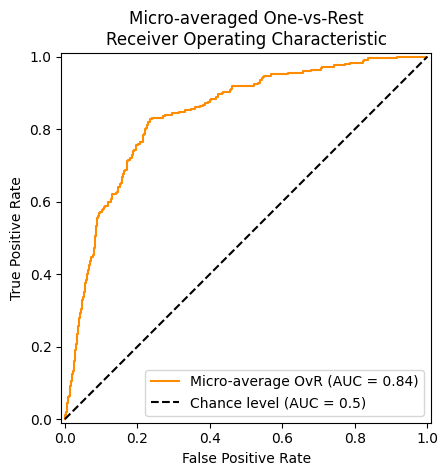

In [248]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_pred.ravel(),
    name="Micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)